In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.stats as stats 
from shapely.geometry import Point
%matplotlib inline

In [4]:
nypd = pd.read_csv('../data/nypd.csv')
nypd['Date'] = pd.to_datetime(nypd['OCCUR_DATE'])
nypd = nypd.drop('OCCUR_DATE', axis=1)

In [5]:
nypd['Month'] = nypd.Date.dt.month 


In [6]:
nypd['Year'] = nypd.Date.dt.year

In [7]:
#dropping string object, need geometry
nypd = nypd.drop('Lon_Lat', axis=1)


In [8]:
#adding geometry objects for mapping
nypd['points'] = nypd.apply(lambda srs: Point( srs['Longitude'] , srs['Latitude']), axis=1)

In [9]:
killed = nypd.loc[nypd.STATISTICAL_MURDER_FLAG == True]

In [10]:
#dividing dataframes into boroughs
bronx = nypd.loc[nypd.BORO == 'BRONX']
brooklyn = nypd.loc[nypd.BORO == 'BROOKLYN']
queens = nypd.loc[nypd.BORO == 'QUEENS']
staten = nypd.loc[nypd.BORO == 'STATEN ISLAND']
manhattan = nypd.loc[nypd.BORO == 'MANHATTAN']

In [11]:
#dividing borough dataframes into 
bx_k = bronx.loc[bronx.STATISTICAL_MURDER_FLAG == True]
brooklyn_k = brooklyn.loc[brooklyn.STATISTICAL_MURDER_FLAG == True]
queens_k = queens.loc[queens.STATISTICAL_MURDER_FLAG == True]
staten_k = staten.loc[staten.STATISTICAL_MURDER_FLAG == True]
manhattan_k = manhattan.loc[manhattan.STATISTICAL_MURDER_FLAG == True]



In [12]:
#assigning total murders by borough
bx_killed, bk_killed, queens_killed, staten_killed, manhattan_killed = bx_k.count()['INCIDENT_KEY'], brooklyn_k.count()['INCIDENT_KEY'], queens_k.count()['INCIDENT_KEY'], staten_k.count()['INCIDENT_KEY'], manhattan_k.count()['INCIDENT_KEY']

In [17]:
geo_k = gpd.GeoDataFrame(killed, geometry = 'points')

In [23]:
#making a geopandas dataframe to plot spatially 
geo_ny = gpd.GeoDataFrame(nypd)
geo_ny = geo_ny.set_geometry('points')

In [180]:
#geodataframes of kills by boro
geo_bronx = geo_k[geo_k.BORO == 'BRONX']
geo_bk = geo_k[geo_k.BORO == 'BROOKLYN']
geo_qns = geo_k[geo_k.BORO == 'QUEENS']
geo_st = geo_k[geo_k.BORO == 'STATEN ISLAND']
geo_mn = geo_k[geo_k.BORO == 'MANHATTAN']

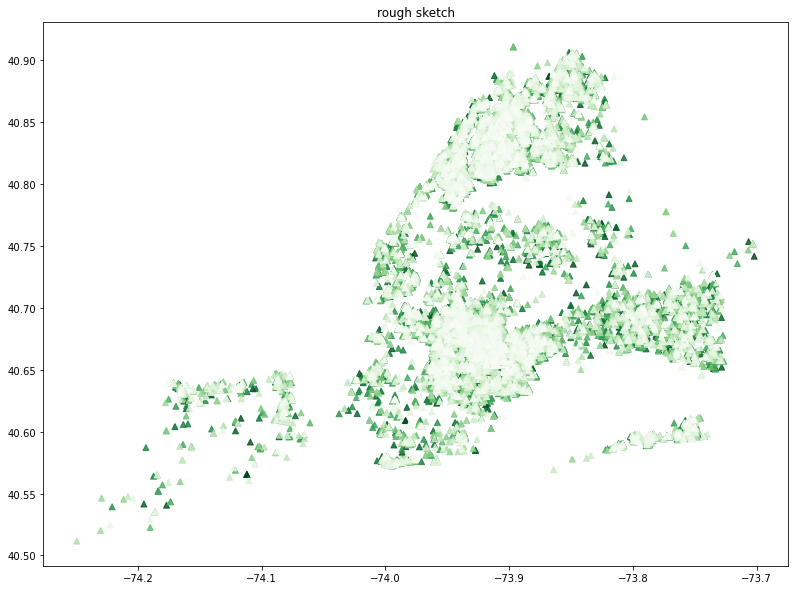

In [25]:
ax = geo_ny.plot(figsize=(15, 10), marker = '^', cmap='Greens_r', alpha=.8)
ax.set_title('rough sketch');


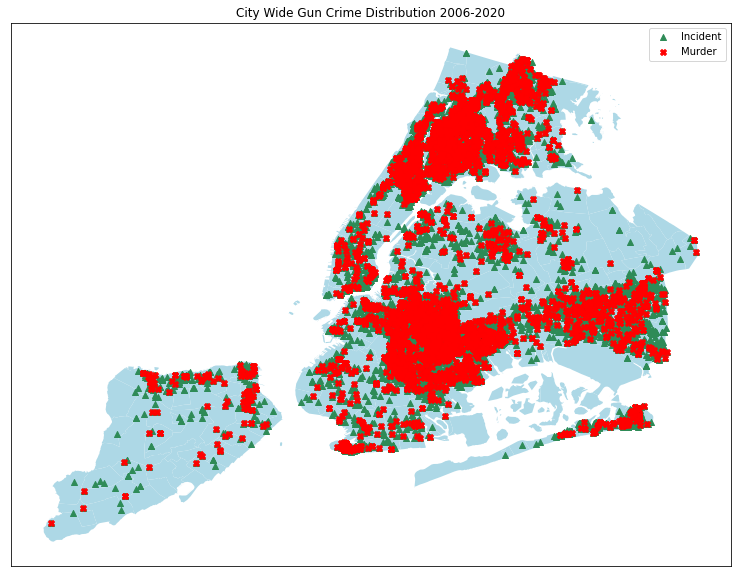

In [26]:
ny_map = gpd.read_file('../data/map.geojson')
fig, ax = plt.subplots(figsize=(15, 10))
ny_map.plot(color = 'lightblue', ax=ax)
geo_ny.plot(marker = '^', color = 'seagreen', ax = ax, label = 'Incident')
geo_k.plot(marker = 'X', color = 'red', ax = ax, label = 'Murder')
ax.set_title('City Wide Gun Crime Distribution 2006-2020')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.savefig('../images/City-Wide.png');

In [62]:
total_deaths_by_year = []
for name, group in killed.groupby('Year'):
    print(name)
    total_deaths_by_year.append(group.count()['INCIDENT_KEY'])

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [63]:
total_deaths_by_year = np.array(total_deaths_by_year)

In [64]:
total_incidents_by_year = []
for name, group in nypd.groupby('Year'):
    total_incidents_by_year.append(group.count()['INCIDENT_KEY'])
    

In [65]:
total_incidents_by_year = np.array(total_incidents_by_year)

In [66]:
rate_of_murder = total_deaths_by_year / total_incidents_by_year 

In [67]:
rate_of_murder

array([0.21654501, 0.19766826, 0.18488253, 0.19037199, 0.21099476,
       0.1923672 , 0.16715201, 0.1665422 , 0.16939891, 0.19735007,
       0.18460265, 0.17956656, 0.21240799, 0.18924509, 0.18589083])

In [68]:
murder_rate = pd.Series(rate_of_murder, index=range(2006, 2021))

In [73]:
yearly = pd.DataFrame(murder_rate, columns = ['murder_rate'])

In [78]:
yearly['total_deaths'] = total_deaths_by_year
yearly['total_incidents_by_year'] = total_incidents_by_year 

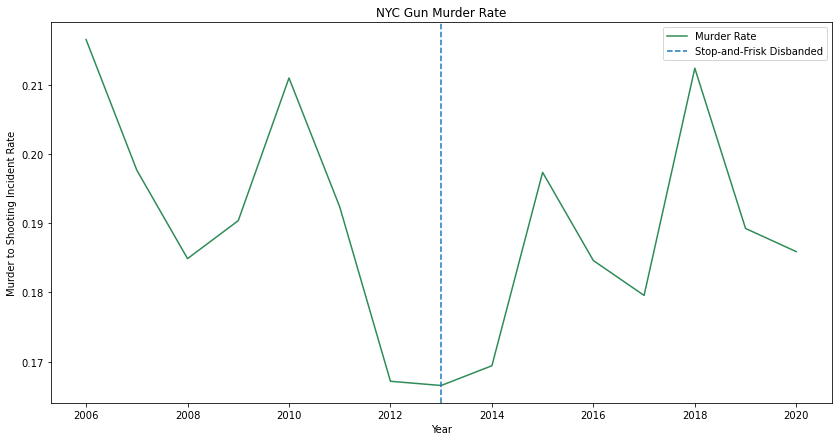

In [91]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(yearly.index, yearly.murder_rate, color='seagreen', label='Murder Rate')
ax.axvline(2013, linestyle = '--', label = 'Stop-and-Frisk Disbanded')
ax.set_title('NYC Gun Murder Rate')
ax.set_xlabel('Year')
ax.set_ylabel('Murder to Shooting Incident Rate')
plt.savefig('../images/Murder-Rate.png')
ax.legend();

In [121]:
#calculates borough murder rate by year 
def kill_stat(df, df_k):
    incidents = []
    deaths = []
    for name, group in df.groupby('Year'):
        incidents.append(group.count()['INCIDENT_KEY'])
    for name, group in df_k.groupby('Year'):
        deaths.append(group.count()['INCIDENT_KEY'])
    incidents = np.array(incidents)
    deaths = np.array(deaths)
    return deaths/incidents

In [125]:
yearly['Brooklyn'] = kill_stat(brooklyn, brooklyn_k)
yearly['Queens'] = kill_stat(queens, queens_k)
yearly['Manhattan'] = kill_stat(manhattan, manhattan_k)
yearly['Staten Island'] = kill_stat(staten, staten_k)

In [126]:
yearly

,murder_rate,total_deaths,total_incidents_by_year,Bronx,Brooklyn,Queens,Manhattan,Staten Island
2006,0.216545,445,2055,0.241197,0.207059,0.199324,0.208333,0.245283
2007,0.197668,373,1887,0.174484,0.212485,0.201681,0.197425,0.180000
2008,0.184883,362,1958,0.171484,0.201274,0.159509,0.169884,0.275362
2009,0.190372,348,1828,0.185255,0.202597,0.172662,0.183673,0.181818
2010,0.210995,403,1910,0.182857,0.226087,0.260417,0.166667,0.205882
2011,0.192367,373,1939,0.199650,0.182360,0.208333,0.190698,0.200000
2012,0.167152,287,1717,0.171375,0.168971,0.182759,0.127551,0.163265
2013,0.166542,223,1339,0.167116,0.175379,0.189189,0.130435,0.076923
2014,0.169399,248,1464,0.168161,0.138436,0.197248,0.230769,0.279070
2015,0.197350,283,1434,0.173594,0.204117,0.219512,0.203209,0.200000


In [127]:
nyc = gpd.read_file('../data/map.geojson')

In [131]:
bronx_map = nyc[nyc.borough == 'Bronx']
brooklyn_map = nyc[nyc.borough == 'Brooklyn']
queens_map = nyc[nyc.borough == 'Queens']
manhattan_map = nyc[nyc.borough == 'Manhattan']
staten_map = nyc[nyc.borough == 'Staten Island']

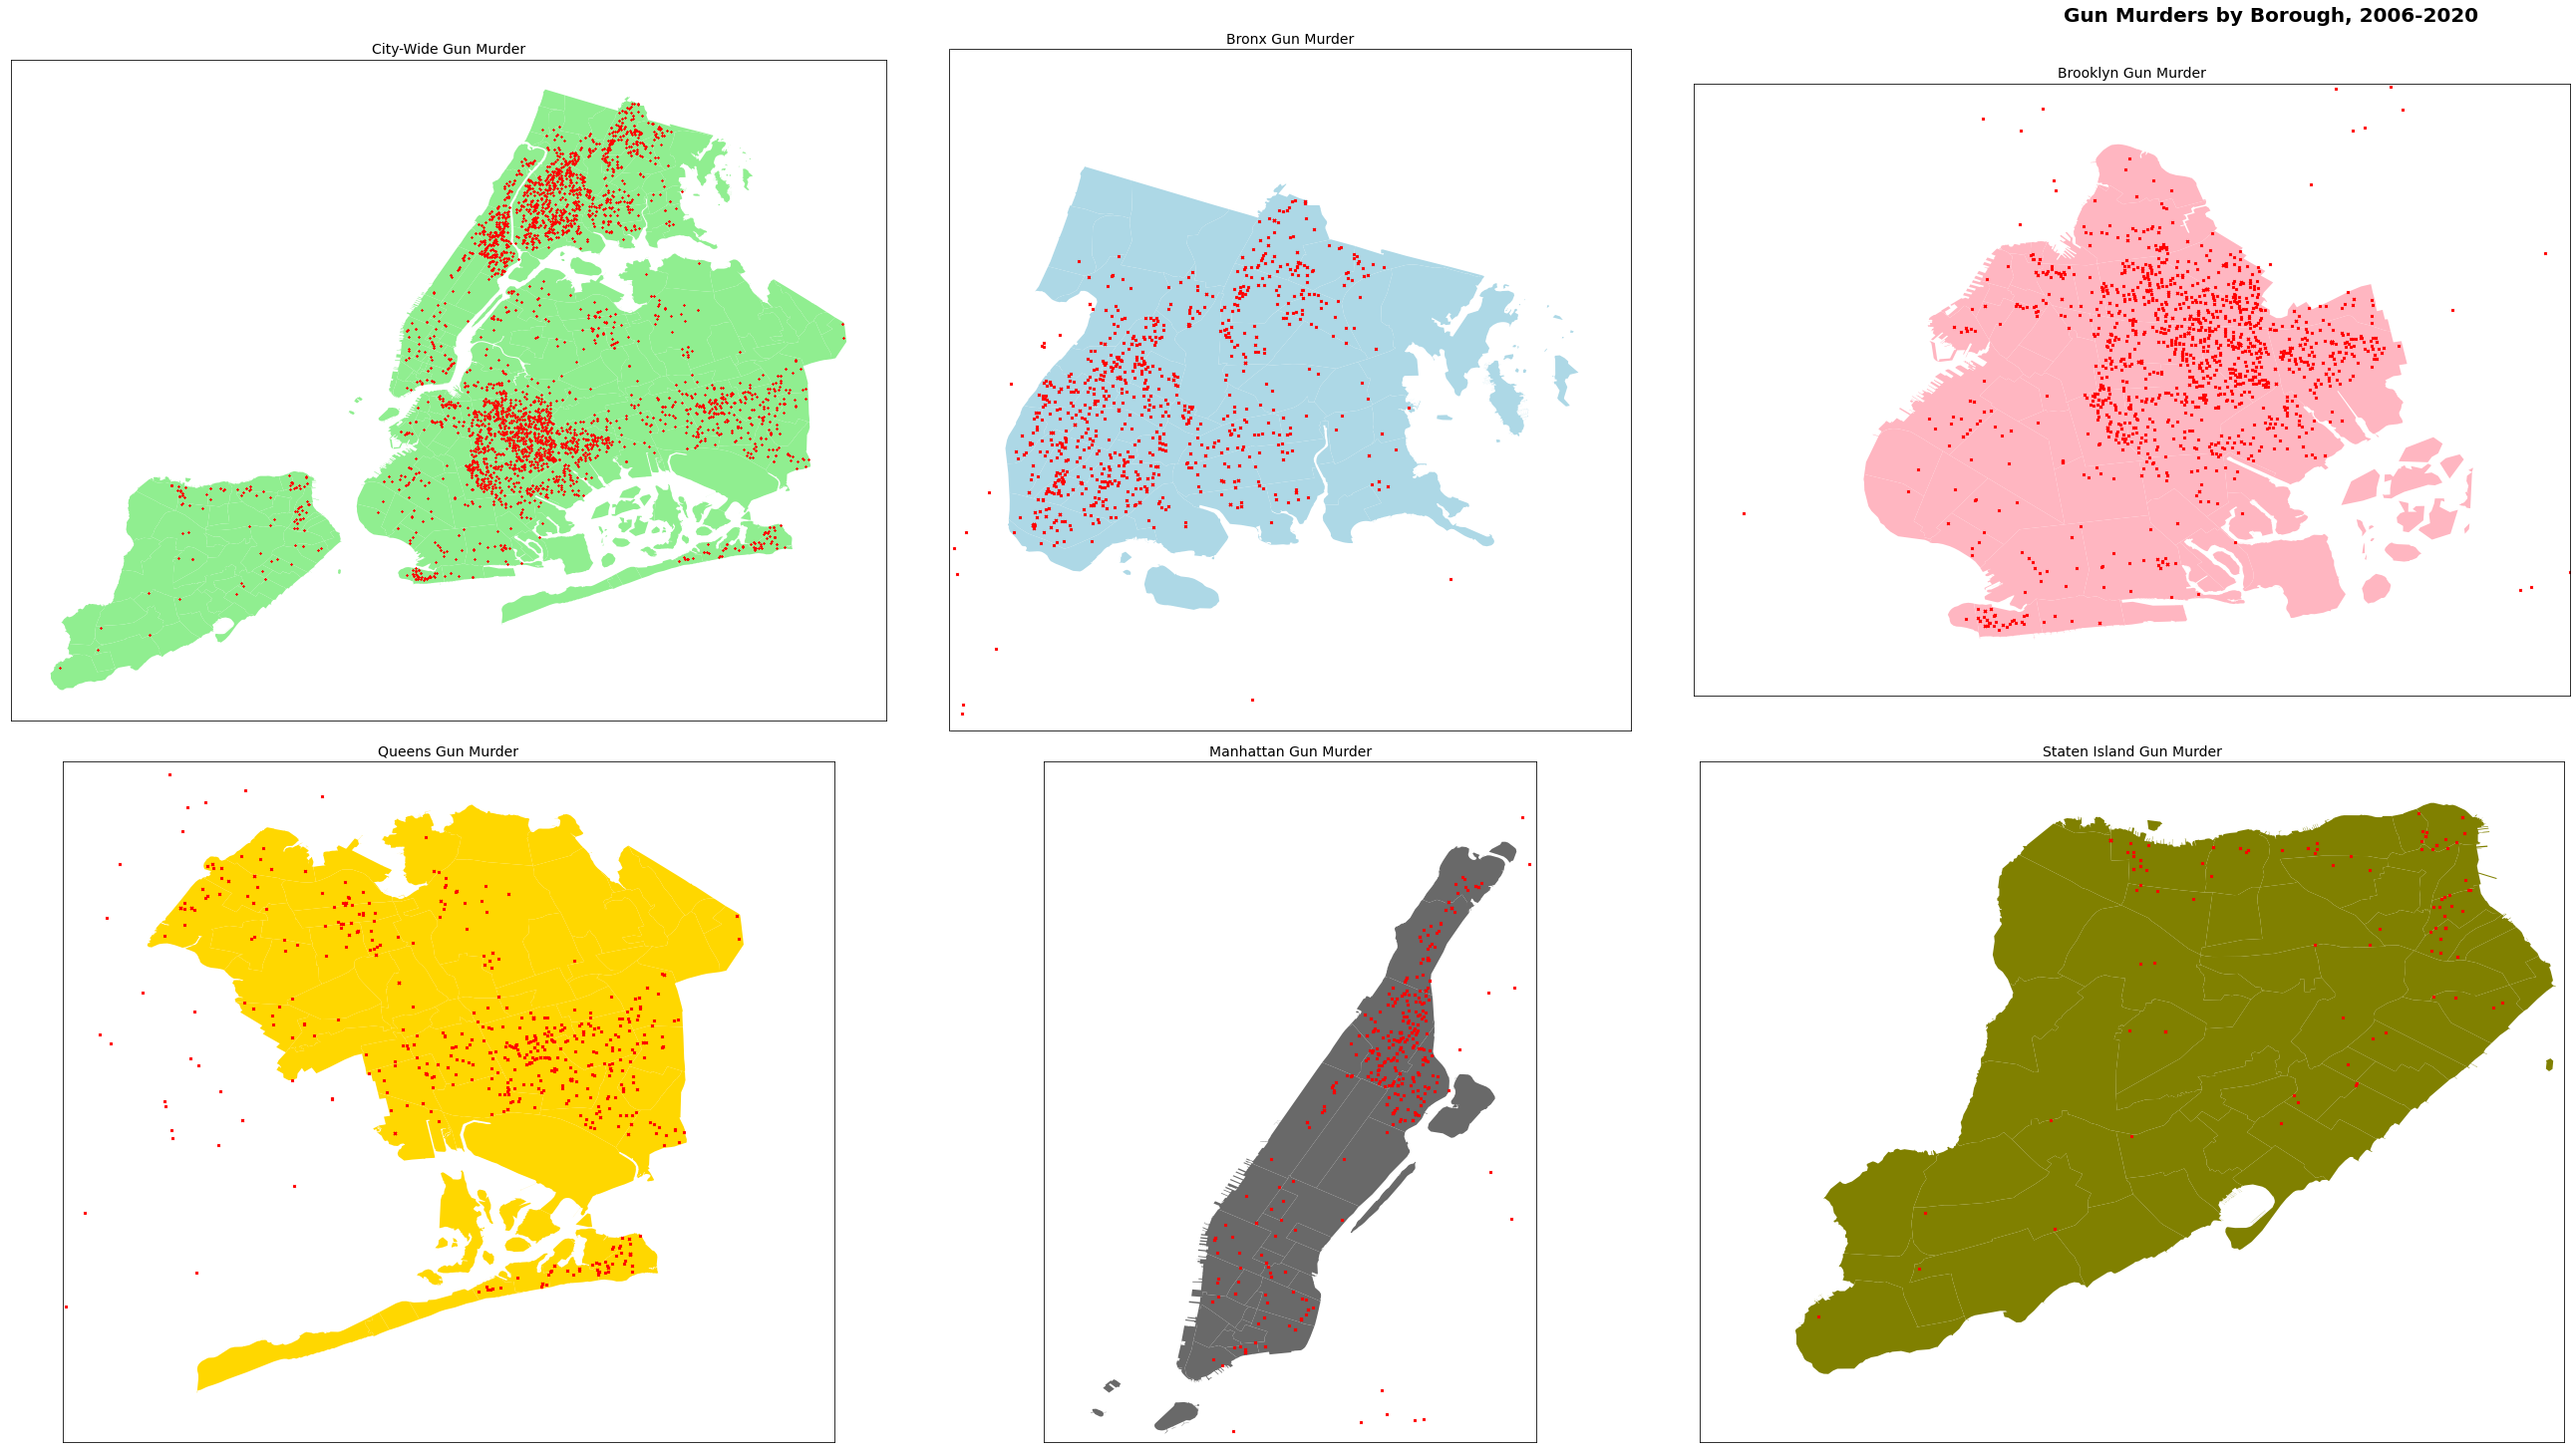

In [243]:
fig, axs = plt.subplots(2, 3, figsize=(36, 20))
axs=axs.flatten()

nyc.plot(ax=axs[0], color = 'lightgreen')
geo_k.plot(ax=axs[0], marker = "x", color = 'red', markersize = 2)
axs[0].set_title('City-Wide Gun Murder', fontsize=14)


bronx_map.plot(ax=axs[1], color = 'lightblue')
geo_bronx.plot(ax=axs[1], color = 'red', marker = 'x', markersize=6)
axs[1].set_title('Bronx Gun Murder', fontsize=14)
axs[1].set_ylim(40.75, 40.95)
axs[1].set_xlim(-73.95, -73.75)


brooklyn_map.plot(ax=axs[2], color = 'lightpink')
geo_bk.plot(ax=axs[2], color = 'red', marker = 'x', markersize = 6)
axs[2].set_title('Brooklyn Gun Murder', fontsize=14)
axs[2].set_ylim(40.55, 40.76)
axs[2].set_xlim(-74.1, -73.8)


queens_map.plot(ax=axs[3], color = 'gold')
geo_qns.plot(ax=axs[3], color = 'red', marker = 'x', markersize = 6)
axs[3].set_title('Queens Gun Murder', fontsize=14)
axs[3].set_xlim(-74.0, -73.66)
axs[3].set_ylim(40.52, 40.82)

manhattan_map.plot(ax=axs[4], color = 'dimgray')
geo_mn.plot(ax=axs[4], color = 'red', marker = 'x', markersize = 6)
axs[4].set_title('Manhattan Gun Murder', fontsize=14)
axs[4].set_xlim(None,-73.9)
axs[4].set_ylim(40.68, None)

staten_map.plot(ax=axs[5], color = 'olive')
geo_st.plot(ax=axs[5], color = 'red', marker = 'x', markersize = 6)
axs[5].set_title('Staten Island Gun Murder', fontsize=14)
axs[5].set_xlim(None, -74.05)
axs[5].set_ylim(None, 40.66)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.text(.8, 1, 'Gun Murders by Borough, 2006-2020', fontsize=20, fontweight='bold')

fig.tight_layout()
plt.savefig('../images/borough-murders.png');